# MJD and real market data

In this mini-project, we attempt to make contact with some real market data, using the MJD model. The goal is twofold: first, we fit the MJD model's parameters to European call options of any asset; then, we use the calibrated parameters to perform an (Out-Of-Sample) test by benchmarking the model against European put options of the same asset.

In [11]:
import numpy as np
import math
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import minimize, newton
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.optimize import brentq
from scipy.integrate import quad
from sklearn.metrics import r2_score

from dateutil import parser
from dateutil.tz import tzutc

sns.set_style('darkgrid')

### Calibration of MJD parameters using call option data

We begin by defining functions to calculate the fair-market price of a European call option using the Merton Jump-Diffusion model as well as the Geometric Brownian Motion model.

In [3]:
# function to calculate fair-market call price using B-S model
def BS_call(S0, mu, r, sigma, t, K):
    '''
    Black-Scholes Call Option formula
    
    Parameters:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    mu: Expected return of the underlying asset
    
    Return:
    Black-Scholes value of call option (float)
    '''
    
    d1 = (np.log(S0/K) + (mu + r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    BS_call_value = S0*(np.exp(mu*t))*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    
    return BS_call_value


# function to calculate fair-market call price using MJD model
def MJD_call(S0, mu, r, sigma, lam, alpha, delta, t, K):
    '''
    MJD Call Option formula
    
    Parameters:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    mu: Expected return of the underlying asset
    lam: Jump intensity
    alpha: Mean of jump size
    delta: Std dev of jump size
    k: Expected percentage jump size
    
    Return:
    MJD value of call option (float)
    '''
    
    k = np.exp(alpha + 0.5*delta**2) - 1

    MJD_call_value = 0

    mu1 = mu - lam*k

    for n in range(0, 51): # sum from n=0 to 50, as higher n terms contribute negligibly
        sigma_n = np.sqrt(sigma**2 + (n * delta**2)/t)
        S0_n = S0 * np.exp(n * (alpha + 0.5 * delta**2))  # Adjusted stock price for n jumps

        MJD_call_value += BS_call(S0_n, mu1, r, sigma_n, t, K)*((lam*t)**n)/math.factorial(n)
    
    return np.exp(-lam*t)*MJD_call_value

We define a function to evaluate the implied volatility of the asset, assuming an underlying GBM.

We also define an error function, which calculates the $L^2$ (root mean square) distance between the actual derivative (call option) and the prediction by the MJD.

In [ ]:
# Implied volatility function using Newton-Raphson method
def find_implied_volatility(S, K, T, r, market_price, tolerance=1e-5, max_iterations=200):
    """
    Finds the implied volatility (sigma) for a call option
    using the Newton-Raphson method.
    """
    intrinsic_value = np.maximum(S - K * np.exp(-r * T), 0)
    if market_price < intrinsic_value - tolerance: return np.nan
    def objective_func(sigma):
        return BS_call(S, 0, r, sigma, T, K) - market_price
    def vega_func(sigma):
        # We need bsm_vega
        if T == 0 or sigma <= 0 or T < 0: return 0
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        return S * norm.pdf(d1) * np.sqrt(T)
    try:
        iv = newton(func=objective_func, x0=0.5, fprime=vega_func, tol=tolerance, maxiter=max_iterations)
        return iv if iv > 0 else np.nan
    except RuntimeError:
        return np.nan


# Error function for optimization
def calculate_total_error(params, S, r, T, market_options):
    """
    This is the objective function for the optimizer.
    It calculates the Root Mean Squared Error (RMSE) between
    MJD model prices and real market prices.
    
    params: A list [sigma, lam, alpha, delta]
    market_options: A list of dicts: [{'strike': K, 'price': P}]
    """
    
    sigma, lam, alpha, delta = params
    
    # Parameter sanity checks
    # Volatilities and jump frequency must be positive
    if sigma <= 0.01 or lam < 0 or delta <= 0.01:
        return 1e9 # Return a huge error to penalize
    
    sum_squared_error = 0.0
    
    for option in market_options:
        K = option['strike']
        market_price = option['price']
        
        model_price = MJD_call(S, 0, r, sigma, lam, alpha, delta, T, K)
        
        sum_squared_error += (model_price - market_price)**2
        
    # Return the Root Mean Squared Error (RMSE)
    return np.sqrt(sum_squared_error / len(market_options))

The main calibration function comes next, and consists of the following crucial steps:

- Fetch the current stock price S, risk-free rate r, and a list of call options for a specific expiration T (30-90 days out) using yfinance.

- Filter this list to create calls_clean, which only contains liquid options with real market prices. This is the "in-sample" or "training" dataset.

- Define the theoretical model: Use the analytical MJD call pricing function, conditioned on a set of 4 MJD parameters (sigma, lam, alpha, delta).

- Begin with a guess for the 4 MJD parameters. Loop through every call option in calls_clean and compares the market_price to the price predicted by theory. Use scipy.optimize.minimize to minimize the error and find the best possible set of parameters.

In [19]:
# Calibration function
def calibrate_mjd_model(ticker_symbol):
    """
    Main function to fetch data, run calibration, and plot results.
    """
    print(f"--- Starting MJD Calibration for {ticker_symbol} ---")
    
    # STEP 1: Get r, S, and T (we set mu=0, assuming risk-neutral)
    try:
        irx = yf.Ticker("^IRX")
        r = irx.history(period="5d")['Close'].iloc[-1] / 100.0
        if pd.isna(r): r = 0.04 # Fallback interest rate
    except Exception:
        r = 0.04
    print(f"Using Risk-Free Rate (r): {r*100:.3f}%")

    ticker = yf.Ticker(ticker_symbol)
    try:
        S = ticker.history(period="5d")['Close'].iloc[-1]
    except Exception as e:
        print(f"Error fetching stock price: {e}")
        return
    print(f"Current stock price (S): ${S:.2f}")

    # Find a good expiration date (e.g., 30-90 days out)
    expiration_dates = ticker.options
    if not expiration_dates:
        print(f"Error: No options found for {ticker_symbol}.")
        return

    today = datetime.datetime.now()
    selected_exp_date = None
    T = 0
    for exp_str in expiration_dates:
        days_to_expiry = (datetime.datetime.strptime(exp_str, "%Y-%m-%d") - today).days
        if 30 <= days_to_expiry <= 90:
            selected_exp_date = exp_str
            T = days_to_expiry / 365.0
            break
    if selected_exp_date is None:
        print("Error: No suitable expiration date found (30-90 days).")
        return
    print(f"Selected Expiration: {selected_exp_date} (T = {T:.4f} years)")

    # STEP 2: Get and filter market prices (the "ground truth")
    chain = ticker.option_chain(selected_exp_date)
    calls = chain.calls
    calls['market_price'] = (calls['bid'] + calls['ask']) / 2.0
    
    # Filter for liquid options (bid > 0) and use a wide range
    # We want OTM and ITM options to "anchor" the smile
    calls_clean = calls[
        (calls['bid'] > 0.01) & 
        (calls['ask'] > 0.01) &
        (calls['openInterest'] > 5)
    ].copy()
    
    # Create the data structure for our error function
    market_options = calls_clean[['strike', 'market_price']].to_dict('records')
    # Rename 'market_price' to 'price' for our function
    for opt in market_options:
        opt['price'] = opt.pop('market_price')
        
    if not market_options:
        print("No liquid options to calibrate on.")
        return
        
    print(f"Calibrating model using {len(market_options)} liquid call options...")

    # STEP 3: Run the optimization    
    # Initial guess for [sigma, lam, alpha, delta]
    initial_guess = [
        0.20,  # sigma (20% diffusion vol)
        0.5,   # lam (0.5 jumps per year)
        -0.1,  # alpha (-10% avg jump)
        0.3    # delta (30% jump vol)
    ]
    
    # Bounds for the solver (sigma, lam, alpha, delta)
    bounds = [
        (0.01, 2.0),   # sigma (1% to 200%)
        (0.0, 5.0),    # lam (0 to 5 jumps/yr)
        (-1.0, 0.5),   # alpha (avg jump -100% to +50%)
        (0.01, 2.0)    # delta (1% to 200%)
    ]

    # Run the optimizer
    # We pass (S, r, T, market_options) as extra 'args' to the error function
    result = minimize(
        calculate_total_error,
        initial_guess,
        args=(S, r, T, market_options),
        method='L-BFGS-B',  # Limited-memory Broyden–Fletcher–Goldfarb–Shanno algorithm for bounded problems
        bounds=bounds,
        options={'disp': True, 'maxiter': 200}
    )

    if not result.success:
        print("\n--- CALIBRATION FAILED ---")
        print(result.message)
        return

    # Step 4: Analyze and plot results
    print("\n--- CALIBRATION SUCCESSFUL ---")
    calibrated_params = result.x
    final_rmse = result.fun
    
    print(f"Final RMSE: {final_rmse:.4f}")
    print(f"Calibrated sigma: {calibrated_params[0]:.4f}")
    print(f"Calibrated lam: {calibrated_params[1]:.4f}")
    print(f"Calibrated alpha: {calibrated_params[2]:.4f}")
    print(f"Calibrated delta: {calibrated_params[3]:.4f}")
    
    # Plot the results
    # Get BS Implied Volatilities (to compare)
    calls_clean['BS_IV'] = calls_clean.apply(
        lambda row: find_implied_volatility(S, row['strike'], T, r, row['market_price']),
        axis=1
    )

    # Get MJD Implied Volatilities (using our new calibrated model)
    # 1. Get MJD model price
    calls_clean['MJD_Price'] = calls_clean.apply(
        lambda row: MJD_call(S, 0, r, *calibrated_params, T, row['strike']),
        axis=1
    )
    # 2. Back-solve for the IV (implied by the MJD price)
    # This shows what the "MJD smile" looks like
    calls_clean['MJD_IV'] = calls_clean.apply(
        lambda row: find_implied_volatility(S, row['strike'], T, r, row['MJD_Price']),
        axis=1
    )

    plt.figure(figsize=(10, 8))
    plt.plot(calls_clean['strike'], calls_clean['BS_IV'], 'o', label='Market Implied Vol (from B-S)')
    plt.plot(calls_clean['strike'], calls_clean['MJD_IV'], 'r.--', label='Calibrated MJD Model IV')
    plt.axvline(S, color='gray', linestyle='--', label=f'Stock Price (${S:.2f})')
    plt.title(f"Model Calibration using {ticker_symbol} call option (Expiry: {selected_exp_date})")
    plt.xlabel("Strike Price (K)")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

    return S, r, T, calibrated_params, calls_clean, chain



We now test the calibration code on the SPY stock, and save the calibrated parameters. The implied volatility smile of SPY (as calculated using the GBM) is seen below. It shows a departure between the two models (MJD and GBM).

--- Starting MJD Calibration for SPY ---
Using Risk-Free Rate (r): 3.757%
Current stock price (S): $670.97
Selected Expiration: 2025-12-12 (T = 0.0932 years)
Calibrating model using 65 liquid call options...


/var/folders/0z/5w35tx_j2klffm13kv7g4vrh0000gn/T/ipykernel_37139/1305444448.py:89: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(



--- CALIBRATION SUCCESSFUL ---
Final RMSE: 0.0950
Calibrated sigma: 0.1012
Calibrated lam: 2.0736
Calibrated alpha: -0.1040
Calibrated delta: 0.0691


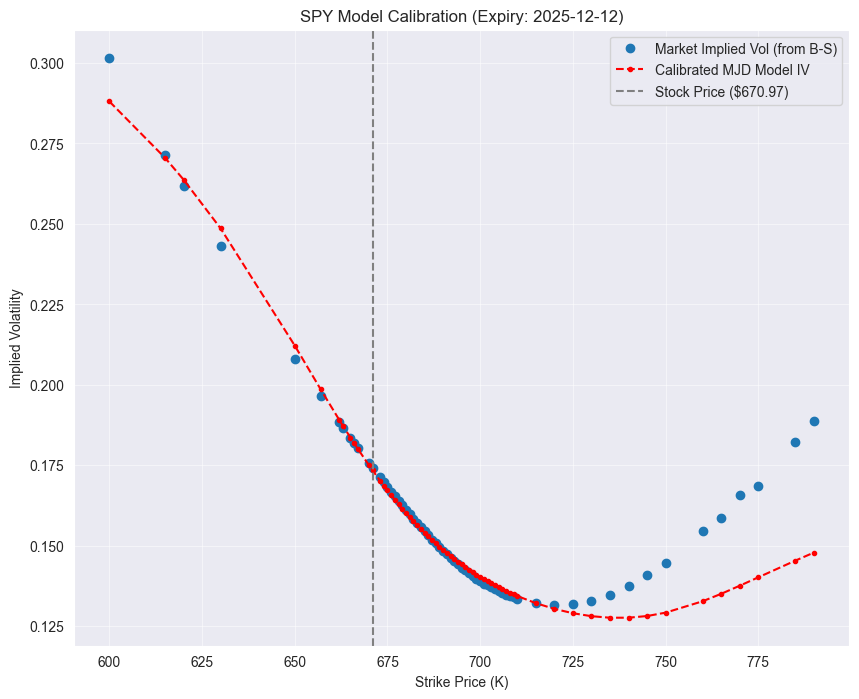

In [8]:
ticker_symbol = "SPY"
# ticker_symbol = "RGTI"

spot_price, rate, Time, calibrated_parameters, calls_cleaned, chains = calibrate_mjd_model(ticker_symbol)

### Backtesting with puts

Next, we test our calibration by backtesting against put option data (which the model has never "seen" before, i.e., Out-Of-Sample data) of SPY. The main steps are as follows:

- Fetch the put option chain for the same expiration T, and filter this to create puts_clean. This is the OOS dataset.

- Make MJD predictions using the 4 calibrated_params from before. For this, we get the MJD call price for each strike using the theory, and then use Put-Call Parity to calculate the theoretical MJD put price.

- Create a benchmark: To prove MJD is better, we compare it to a simple Black-Scholes (BSM) model. We find the at-the-money call option, get its single implied volatility (atm_iv), and use that one atm_iv to price all the puts. 

- Compare and score: Both visually (scatter plot of actual put values vs the model predictions) as well as quantitatively (from the $R^2$ values for both models).

In [20]:
# Backtesting function
def run_put_backtest(S, r, T, calibrated_params, calls_clean, chain, ticker_symbol):
    """
    Runs an out-of-sample backtest on put options using
    the pre-calibrated MJD parameters.
    
    Parameters:
    S (float): Current stock price
    r (float): Risk-free interest rate
    T (float): Time to expiration (years)
    calibrated_params : list or tuple
        The calibrated [sigma, lam, alpha, delta] parameters.
    calls_clean : pd.DataFrame
        The cleaned calls DataFrame used for calibration.
    chain : yfinance option chain object
        The option chain for the selected expiration date.
    ticker_symbol : str
        The stock ticker to backtest against.
    """
    
    print(f"--- Running OOS Put Backtest for {ticker_symbol} ---")
    print("Using Calibrated MJD Parameters:")
    print(f"sigma: {calibrated_parameters[0]:.4f}")
    print(f"lam: {calibrated_parameters[1]:.4f}")
    print(f"alpha: {calibrated_parameters[2]:.4f}")
    print(f"delta: {calibrated_parameters[3]:.4f}")
     
    # Get Puts (test data)
    puts = chain.puts
    puts['market_price'] = (puts['bid'] + puts['ask']) / 2.0
    puts_clean = puts[
        (puts['bid'] > 0.01) & 
        (puts['ask'] > 0.01) &
        (puts['openInterest'] > 5)
    ].copy()

    if puts_clean.empty:
        print("No liquid puts found to run the OOS test.")
        return

    print(f"\nTesting model against {len(puts_clean)} liquid put options...")

    # STEP 1: Calculate MJD Put Prices
    # We use Put-Call Parity: P_mjd = C_mjd - S + K*exp(-rT)
    puts_clean['MJD_Call_Price'] = puts_clean.apply(
        lambda row: MJD_call(S, 0, r, *calibrated_params, T, row['strike']), axis=1)
    
    puts_clean['MJD_Put_Price'] = puts_clean['MJD_Call_Price'] - S + puts_clean['strike'] * np.exp(-r * T)
    
    # STEP 2: Calculate Benchmark B-S Put Prices
    atm_iv = 0.3 # Default fallback
    if not calls_clean.empty:
        # Find the market call with strike closest to S
        atm_call = calls_clean.iloc[(calls_clean['strike'] - S).abs().argmin()]
        atm_call_price = atm_call['market_price']
        atm_call_strike = atm_call['strike']
        
        # Calculate its IV
        iv = find_implied_volatility(S, atm_call_strike, T, r, atm_call_price)
        if not pd.isna(iv):
            atm_iv = iv
            
    print(f"Using (benchmark) B-S IV: {atm_iv:.4f}")

    # P_bsm = C_bsm - S + K*exp(-rT)
    puts_clean['BS_Call_Price'] = puts_clean.apply(
        lambda row: BS_call(S, 0, r, atm_iv, T, row['strike']), axis=1)
    
    puts_clean['BSM_Put_Price'] = puts_clean['BS_Call_Price'] - S + puts_clean['strike'] * np.exp(-r * T)
    

    # STEP 3: Calculate R-Squared
    # Ensure no NaNs, which would break r2_score
    puts_clean_final = puts_clean.dropna(subset=['market_price', 'MJD_Put_Price', 'BSM_Put_Price'])
    
    if puts_clean_final.empty:
        print("No valid data to calculate R-Squared.")
        return

    y_true = puts_clean_final['market_price']
    y_pred_mjd = puts_clean_final['MJD_Put_Price']
    y_pred_bs = puts_clean_final['BSM_Put_Price']
    
    r2_mjd = r2_score(y_true, y_pred_mjd)
    r2_bs = r2_score(y_true, y_pred_bs)
    
    print("\n--- Model Fit Statistics (R-Squared) ---")
    print(f"MJD Model R²:   {r2_mjd:.4f}")
    print(f"B-S Model R²:   {r2_bs:.4f}")
    
    if r2_mjd > r2_bs:
        print("=> MJD model is a better fit for the put data.")
    else:
        print("=> MJD model is NOT a better fit than simple B-S.")



    # STEP 4: Plot Market Price vs. Model Price
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred_mjd, 
                label=f'Calibrated MJD Model (R² = {r2_mjd:.4f})', alpha=0.7)
    plt.scatter(y_true, y_pred_bs, 
                label=f'Simple B-S (atm_iv={atm_iv:.2f}, R² = {r2_bs:.4f})', alpha=0.7, marker='x') 
    
    
    # Plot the y=x "perfect fit" line
    max_price = puts_clean['market_price'].max()
    plt.plot([0, max_price], [0, max_price], 'r--', label='Perfect fit (y=x)')
    
    plt.title(f"{ticker_symbol}: Calibrate on Calls, Backtest on Puts")
    plt.xlabel("Actual Market Put Price", fontsize=12)
    plt.ylabel("Model-Predicted Put Price", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.axis('equal') # Make axes equal
    plt.show()

--- Running OOS Put Backtest for SPY ---
Using Calibrated MJD Parameters:
sigma: 0.1012
lam: 2.0736
alpha: -0.1040
delta: 0.0691

Testing model against 68 liquid put options...
Using (benchmark) B-S IV: 0.1742

--- Model Fit Statistics (R-Squared) ---
MJD Model R²:   0.9852
B-S Model R²:   0.9630
=> MJD model is a better fit for the put data.


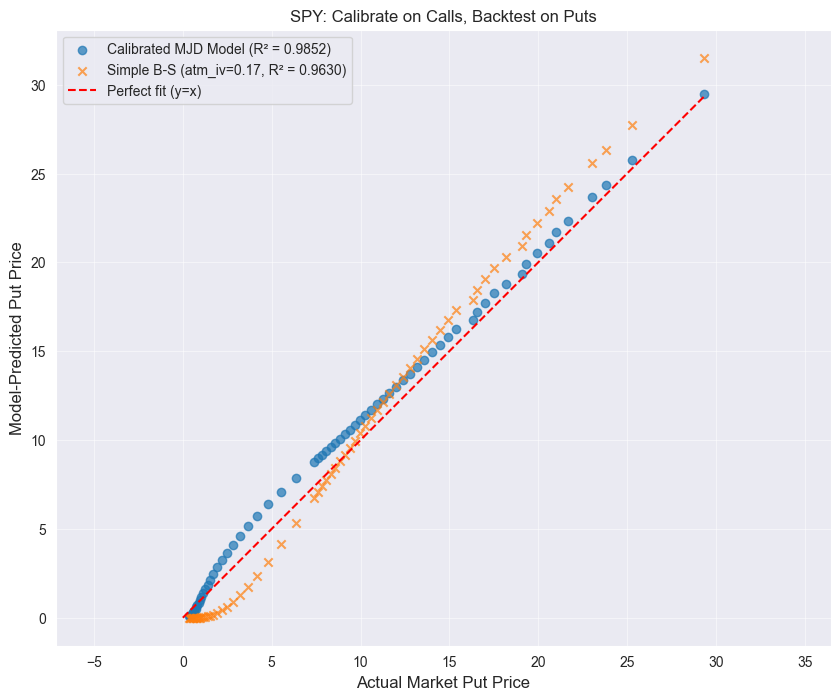

In [21]:
run_put_backtest(spot_price, rate, Time, calibrated_parameters, calls_cleaned, chains, ticker_symbol)

From the above plot (as well as the $R^2$ analysis), we can see that the predictions by the calibrated Merton's Jump-Diffusion model are better than those by a simple Black-Scholes model.